In [5]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
def drop_records_brand_equal_model(df):
    """
    Entfernt alle Zeilen, in denen brand und model nach Normalisierung identisch sind.
    """
    def normalize(text):
        if pd.isna(text):
            return ""
        return re.sub(r"[^a-z0-9]", "", text.lower())

    df = df.copy()
    df["brand_norm"]  = df["brand"].apply(normalize)
    df["model_norm"]  = df["model"].apply(normalize)

    # Zeilen behalten, bei denen die Normalisierungen unterschiedlich sind
    df = df[df["brand_norm"] != df["model_norm"]].reset_index(drop=True)

    df.drop(columns=["brand_norm", "model_norm"], inplace=True)
    return df
#--------------------------------------   


    
# Daten laden
df = pd.read_csv('../data.csv')
    
# entferne Duplikate  
df = df.drop_duplicates(subset= ['brand', 'model', 'color', 'registration_date', 'year',
    'price_in_euro', 'power_kw', 'power_ps', 'transmission_type',
    'fuel_type', 'fuel_consumption_l_100km', 'fuel_consumption_g_km',
    'mileage_in_km', 'offer_description']) 

# Droppe zweite Index Spalte
if 'Unnamed: 0' in df.columns:
    df = df.drop('Unnamed: 0', axis=1)
'''
# andere fuel Types als Diesel und Petrol in einen anderen Datensatz extrakhieren    
valid_fuel_types = ['Hybrid', 'Diesel Hybrid', 'Electric', 'LPG', 'CNG', 'Ethanol', 'Hydrogen', 'Other']
df_before_filter = df.copy()    
df_other_fuel_types = df_before_filter[(~df_before_filter['fuel_type'].isin(['Diesel', 'Petrol'])) & (df_before_filter['fuel_type'].isin(valid_fuel_types))].reset_index(drop=True)
    # evtl. den ersten Teil  ~df_before_filter['fuel_type'].isin(['Diesel', 'Petrol'])) & rausnehmen? Denn ist ja doppelt, denn Bedingung wird ja in dem 2. Teil ja schon überpüft wird
'''   
df = df.loc[df['fuel_type'].isin(['Diesel', 'Petrol'])]
df = df.loc[df['fuel_consumption_g_km'].str.contains(r'g/km', na=False)] # hiermit werden hybride Fahrzeuge rausgefiltert (haben Reichweite in g/km drin, aber trotzdem fuel Type Petrol/ Diesel
df = df.reset_index(drop=True)

        
# Zeilen mit falschen Jahreszahlen werden herausgenommen
yearsToFilter = list(df['year'].unique()[:29])
filt = [val in yearsToFilter for val in df['year']]
df = df[filt]

def Electrics_Reichweite(df):
# Filtere die Zeilen, bei denen "fuel_type" = "Electric" und "fuel_consumption_g_km" das Wort "Reichweite" enthält
    e_mit_reichweite = (df["fuel_type"] == "Electric") & (df["fuel_consumption_g_km"].astype(str).str.contains("Reichweite", na=False))
    # Cutte in der Spalte "fuel_consumption_g_km" beim ersten Leerzeichen
    df.loc[e_mit_reichweite, "fuel_consumption_g_km"] = df.loc[e_mit_reichweite, "fuel_consumption_g_km"].astype(str).str.split().str[0]
    # Kopiere Werte von "fuel_consumption_g_km" in die Spalte "fuel_consumption_l_100km"
    df.loc[e_mit_reichweite, "fuel_consumption_l_100km"] = df.loc[e_mit_reichweite, "fuel_consumption_g_km"]
    
    return df

df = Electrics_Reichweite(df)
            
def clean_fuel_consumption(value): 
    if pd.isna(value) or 'l/100 km' not in str(value):
        return np.nan
    try:
        return float(value.split(' ')[0].replace(',', '.'))
    except:
        return np.nan
                    
def clean_fuel_consumption_g(value):
    if pd.isna(value) or value == '- (g/km)' or 'g/km' not in str(value): # Bei Elektroautos steht Reichweite
        return np.nan
    try:
        return float(value.split(' ')[0])
    except:
        return np.nan
                    
df['fuel_consumption_l_100km'] = df['fuel_consumption_l_100km'].apply(clean_fuel_consumption)
df['fuel_consumption_g_km'] = df['fuel_consumption_g_km'].apply(clean_fuel_consumption_g)      


# Funktion zur Berechnung fehlender l/100km Werte, wenn g/km gegeben ist
def calculate_fuel_consumption(row):

    conversion_factor = 0.043103448275862

    if pd.isna(row['fuel_consumption_l_100km']) or row['fuel_consumption_l_100km'] == 0:
        if pd.notna(row['fuel_consumption_g_km']) and row['fuel_consumption_g_km'] != 0:
            return row['fuel_consumption_g_km'] * conversion_factor
        else:
            return np.nan
    else:
        return row['fuel_consumption_l_100km']

df['fuel_consumption_l_100km'] = df.apply(calculate_fuel_consumption, axis=1)

# Droppe wo brand = model
df = drop_records_brand_equal_model(df) 

    
# Spalten ins numerische umwandeln
for col in ['power_ps', 'power_kw']:
        df[col] = df[col].astype(float)
df['mileage_in_km'] = pd.to_numeric(df['mileage_in_km'], errors='coerce')
df['price_in_euro'] = pd.to_numeric(df['price_in_euro'], errors='coerce')
df['year'] = pd.to_numeric(df['year'], errors='coerce')   

# Encoding vom Datum ins numerische
df['registration_date'] = pd.to_datetime(df['registration_date'], format='%m/%Y', errors='coerce')
df['registration_month'] = df['registration_date'].dt.month
df['registration_year'] = df['registration_date'].dt.year


In [13]:
numeric  = list(df.select_dtypes('number').columns)

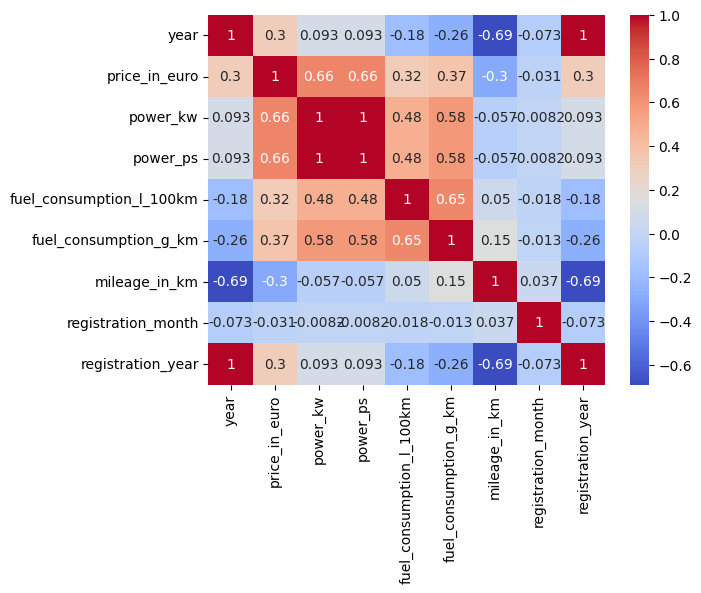

In [14]:
sns.heatmap(df[numeric].corr(), annot=True, cmap='coolwarm')
plt.show()